# Lab 3: Policy Search

Write agents able to play Nim, with an arbitrary number of rows and an upper bound on the number of objects that can be removed in a turn (a.k.a., subtraction game).

- Task3.1: An agent using fixed rules based on nim-sum (i.e., an expert system)
- Task3.2: An agent using evolved rules
- Task3.3: An agent using minmax
- Task3.4: An agent using reinforcement learning

In [1]:
import logging
from collections import namedtuple
import random
from copy import deepcopy
from itertools import accumulate
from operator import xor
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
logging.basicConfig(format="%(message)s", level=logging.INFO)

### The Nim and Nimply classes

In [3]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [4]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k
        self._turn = 0
        # 0 indicates that player 1 should move
        # 1 indicates that player 2 should move

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    @property
    def k(self) -> int:
        return self._k

    @property
    def turn(self) -> int:
        return self._turn

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects
        self._turn = 1 - self._turn

In [5]:
def possible_moves(nim: Nim):
    return [Nimply(r, o) for r, c in enumerate(nim.rows) for o in range(1, c + 1) if nim.k is None or o <= nim.k]

## An agent using fixed rules

### The random strategy

The hardcoded agent can use a set of fixed strategies: the first one consists in removing a random number of sticks from a random row, if the row has one or more sticks.

In [6]:
def random_strategy(nim: Nim, num_law=None, nimming=True):
    moves_list = possible_moves(nim)

    if len(moves_list) > 0:
        move = random.choice(moves_list)
        if nimming:
            nim.nimming(move)
        return move
    else:
        logging.info("No more moves allowed!")

### The nim sum

The following description was taken from [here](https://dmf.unicatt.it/~paolini/divulgazione/mateappl/nim/nim.html).

In a game of nim that involves nim heaps where you can take as many objects as you want from any one of the heaps during your turn, you need to be able to compute a nim sum, that characterizes the configuration of the game.

Here's how to do it:

- Express the number of objects in each nim heap as a binary number, with the only digits being 0 and 1.
- Fill out the smaller binary numbers with '0's on the left, if necessary, so that all the numbers have the same number of digits.
- Sum the binary numbers, but do not carry.
- Replace each digit in the sum with the remainder that results when the digit is divided by 2.
- This yields the nim sum.
- To win at nim, always make a move, when possible, that leaves a configuration with a nim sum of 0. If you cannot do this, your opponent has the advantage, and you have to depend on his or her committing an error in order to win.
    - Note that if the configuration you are given has a nim sum not equal to 0, there always is a move that creates a new configuration with a nim sum of 0. However, there are usually also moves that will yield configurations that give nim sums not equal to 0, and you need to avoid making these.
    - Also note that if you are given a configuration that has a nim sum of 0, there is no move that will create a configuration that also has a nim sum of 0.

In this implementation, the nim sum is calculated as the bitwise xor of the rows.

In [7]:
def nim_sum(state: Nim) -> int:
    *_, result = accumulate(state.rows, xor)
    return result

### The nim sum strategy

The second strategy consists in calculating the nim sum of the current board:
- if it is not zero, evaluate some random moves until a zero nim sum is found.
- if it is zero, perform a random move.

In [8]:
def nim_sum_strategy(nim: Nim, num_law=None, nimming=True):
    if nim_sum(nim) != 0:
        moves_list = possible_moves(nim)
        for move in moves_list:
            temp_nim = deepcopy(nim)
            temp_nim.nimming(move)
            if nim_sum(temp_nim) == 0:
                if nimming:
                    nim.nimming(move)
                return move
    random_strategy(nim)

### The not so smart strategy

This strategy emulates an human (that can make errors), and consists in using the nim sum strategy with a 70% probability (by default) or the random strategy otherwise.

In [9]:
def not_so_smart_strategy(nim: Nim, num_law=None, smartness=0.7, nimming=True):
    if random.random() < smartness:
        return nim_sum_strategy(nim, nimming=nimming)
    else:
        return random_strategy(nim, nimming=nimming)

## The matches

The play_nim function takes some parameters:
- `n` indicates the number of rows on the board.
- `first_strategy` indicates the method used by the first agent to make a move.
- `second_strategy` indicates the method used by the second agent to make a move.
- `who_starts` indicates who makes the first move; it is an even number (tipically 0) to indicate the first agent and an odd number (tipically 1) to indicate the second agent.
- `first_num_law` and `second_num_law` are two special parameters that will be used for the evolved rules.

The first agent will always move first.

In [10]:
def play_nim(n, first_strategy, second_strategy, who_starts, first_num_law=0, second_num_law=0):
    nim = Nim(n)
    #logging.info(f"Initial setting: {nim.rows} - Nim sum: {nim_sum(nim)}")
    nim._turn = who_starts % 2
    while nim:
        if nim.turn == 0: # first agent's turn
            first_strategy(nim, num_law=first_num_law)
            #logging.info(f"First agent's turn: {nim.rows} - Nim sum: {nim_sum(nim)}")
        else: # second agent's turn
            second_strategy(nim, num_law=second_num_law)
            #logging.info(f"Second agent's turn: {nim.rows} - Nim sum: {nim_sum(nim)}")
    return (1 - nim.turn)


In [11]:
def single_game(n, first_strategy, second_strategy, who_starts, first_num_law=0, second_num_law=0):
    winner = play_nim(n, first_strategy, second_strategy, who_starts, first_num_law, second_num_law)
    if winner == 0:
        logging.info("--- The first agent won! ---\n")
    else:
        logging.info("--- The second agent won! ---\n")

In [91]:
def evaluate(first_strategy, second_strategy, first_num_law=0, second_num_law=0, rows=[2, 3, 4, 5], num_matches=100, starter=2):
    for num_rows in rows:
        won = 0
        for match in range(num_matches):
            won += (1 - play_nim(num_rows, first_strategy, second_strategy, match % 2 if starter == 2 else starter % 2, first_num_law, second_num_law))
        logging.info(f"N = {num_rows} - Win ratio: {won/num_matches}")

### First version: second agent's random strategy

In [13]:
NUM_ROWS = 5

In [14]:
logging.info("Game 1:\n N = 5\n Start: First Agent\n First agent: nim sum strategy\n Second agent: random strategy")
single_game(NUM_ROWS, nim_sum_strategy, random_strategy, 0)

logging.info("Game 2:\n N = 5\n Start: Second Agent\n First agent: nim sum strategy\n Second agent: random strategy")
single_game(NUM_ROWS, nim_sum_strategy, random_strategy, 1)

Game 1:
 N = 5
 Start: First Agent
 First agent: nim sum strategy
 Second agent: random strategy
--- The first agent won! ---

Game 2:
 N = 5
 Start: Second Agent
 First agent: nim sum strategy
 Second agent: random strategy
--- The first agent won! ---



### Second version: Everyone is using the nim sum strategy

In [15]:
logging.info("Game 3:\n N = 5\n Start: First Agent\n First agent: nim sum strategy \n Second agent: nim sum strategy")
single_game(NUM_ROWS, nim_sum_strategy, nim_sum_strategy, 0)

logging.info("Game 4:\n N = 5\n Start: Second Agent\n First agent: nim sum strategy\n Second agent: nim sum strategy")
single_game(NUM_ROWS, nim_sum_strategy, nim_sum_strategy, 1)

Game 3:
 N = 5
 Start: First Agent
 First agent: nim sum strategy 
 Second agent: nim sum strategy
--- The first agent won! ---

Game 4:
 N = 5
 Start: Second Agent
 First agent: nim sum strategy
 Second agent: nim sum strategy
--- The second agent won! ---



### Third version: The agent is using the not so smart strategy

This strategy emulates an human (that can make errors), and consists in using the nim sum strategy with a 70% probability or the random strategy otherwise.

In [16]:
logging.info("Game 5:\n N = 5\n Start: First Agent\n First agent: nim sum strategy\n Second agent: not so smart strategy")
single_game(NUM_ROWS, nim_sum_strategy, not_so_smart_strategy, 0)

logging.info("Game 6:\n N = 5\n Start: Second Agent\n First agent: nim sum strategy\n Second agent: not so smart strategy")
single_game(NUM_ROWS, nim_sum_strategy, not_so_smart_strategy, 1)

Game 5:
 N = 5
 Start: First Agent
 First agent: nim sum strategy
 Second agent: not so smart strategy
--- The first agent won! ---

Game 6:
 N = 5
 Start: Second Agent
 First agent: nim sum strategy
 Second agent: not so smart strategy
--- The first agent won! ---



### Some human-like strategies

New strategies have been defined; they are based on feasible human moves and each of them can be executed with five variations, by removing either one, half, one-third, two-third or all the items in the chosen row.

The strategies are:
- shortest row
- longest row
- first row
- last row
- middle row

In [17]:
def items_to_remove(num_law, num):
    assert num > 0
    if num_law == 0: # all the item
        return num
    elif num_law == 1: # one item
        return 1
    elif num_law == 2: # half of the items
        return int((num+1)/2)
    elif num_law == 3: # one-third of the items
        return int((num+2)/3)
    else: # two-third of the items
        return int((num+1)/3) + 1

def shortest_row_strategy(nim: Nim, num_law=0, nimming=True):
    move = min((x for x in enumerate(nim.rows) if x[1] > 0), key=lambda y: y[1])
    move = Nimply(move[0], items_to_remove(num_law, move[1]))
    if nimming:
        nim.nimming(move)
    return move


def longest_row_strategy(nim: Nim, num_law=0, nimming=True):
    move = max((x for x in enumerate(nim.rows)), key=lambda y: y[1])
    move = Nimply(move[0], items_to_remove(num_law, move[1]))
    if nimming:
        nim.nimming(move)
    return move


def first_row_strategy(nim: Nim, num_law=0, nimming=True):
    move = min((x for x in enumerate(nim.rows) if x[1] > 0), key=lambda y: y[0])
    move = Nimply(move[0], items_to_remove(num_law, move[1]))
    if nimming:
        nim.nimming(move)
    return move

def last_row_strategy(nim: Nim, num_law=0, nimming=True):
    move = max((x for x in enumerate(nim.rows) if x[1] > 0), key=lambda y: y[0])
    move = Nimply(move[0], items_to_remove(num_law, move[1]))
    if nimming:
        nim.nimming(move)
    return move


def middle_row_strategy(nim: Nim, num_law=0, nimming=True):
    _list = list(x for x in enumerate(nim.rows) if x[1 > 0])
    move = _list[int(len(_list) / 2)]
    move = Nimply(move[0], items_to_remove(num_law, move[1]))
    if nimming:
        nim.nimming(move)
    return move
    

### The tournament

During the tournament, each strategy (with their variation) is used in a fixed number of matches against the random strategy. Each match is repeated twice, alternating the starting strategy.

At the end, all the winning ratios are compared and a winner is decreed.

In [27]:
NUM_MATCHES = 1000
NUM_ROWS = 5

rules = [shortest_row_strategy, longest_row_strategy, first_row_strategy, last_row_strategy, middle_row_strategy]
num_laws = [0, 1, 2, 3, 4]

evaluations = dict()

for index, rule in enumerate(rules):
    for law in num_laws:
        won = 0
        for match in range(NUM_MATCHES):
            winner = play_nim(NUM_ROWS, rule, random_strategy, match % 2, first_num_law=law)
            won += (1 - winner)
        ratio = won/NUM_MATCHES
        evaluations[f"{rules[index].__name__}, law {law}"] = [index, law, ratio]
        #logging.info(f"{population[index].__name__}, law {law} - Fitness: {fit}")

best = max((x for x in evaluations), key=lambda y: evaluations[y][2])
best_human_strategy = (rules[evaluations[best][0]], evaluations[best][1])
logging.info(f"Best strategy: {best} - Win ratio: {evaluations[best][2]}")

Best strategy: shortest_row_strategy, law 0 - Win ratio: 0.849


### Evaluation phase

The winning strategy is evaluated again: new matches are played all the other strategies. At the end the winning ratio is calculated; if it is high enough, then the strategy is the best possible (so far).

In [28]:
for num_rows in [2, 3, 4, 5]:
    won = 0
    for individual in rules:
        for law in num_laws:
            for match in range(NUM_MATCHES):
                winner = play_nim(
                    NUM_ROWS,
                    best_human_strategy[0],
                    individual,
                    match % 2,
                    first_num_law=best_human_strategy[1],
                    second_num_law=law
                )
                won += (1 - winner)
    logging.info(f"N = {num_rows} - Win ratio: {won/(len(rules)*len(num_laws)*NUM_MATCHES)}")

N = 2 - Win ratio: 0.9
N = 3 - Win ratio: 0.9
N = 4 - Win ratio: 0.9
N = 5 - Win ratio: 0.9


## An agent using evolved rules

#### Individual
An individual is formed by a set of four genes, each gene contains the strategy to use in a certain phase of the game.

#### Gene
A gene is formed by a tuple of `(rule, law)`, previously defined in the human-like strategies.

#### Cross-over
Given two individual, merge them by taking a random $num$ of genes of the first one and $NUM\_ROWS - num$ genes of the second one.

#### Mutation
Replace a random gene of the individual with another random gene.

In [20]:
Individual = namedtuple("Individual", ["genome", "fitness"])

# init the best individual, so that the evolved_strategy function works fine
best_individual = list()
for _ in range(4):
    best_individual.append((random.choice(rules), random.choice(num_laws)))


def random_gene():
    return (random.choice(rules), random.choice(num_laws))


# returns individuals with max fitness (the fittest) but still random
def tournament(population, tournament_size=2):
    return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)


# merge two individuals
def cross_over(g1, g2):
    cut = random.randint(0, len(g1))
    return g1[:cut] + g2[cut:]


# replace a gene of the individual with a random one
def mutation(g):
    point = random.randint(0, len(g) - 1)
    new_gene = random_gene()
    return g[:point] + ([new_gene]) + g[point + 1 :]

#### The evolved strategy
The evolved strategy exploits the four genes of the individual.<br>
As we said, each gene represents a rule:
- The first rule is used if the board contains less then a quarter of the total sticks.
- The second rule is used if the board contains between a quarter and half of the total sticks.
- the third rule is used if the board contains between half and three-quarters of the total sticks.
- the fourth rule is used if the board contains more then three-quarters of the total sticks.

In [21]:
def get_rule(nim: Nim, individual):
    tot_sticks = sum(Nim(len(nim.rows)).rows)
    current_sticks = sum(nim.rows)
    if current_sticks <= tot_sticks/4:
        return individual[0]
    elif current_sticks <= tot_sticks/2:
        return individual[1]
    elif current_sticks <= tot_sticks*3/4:
        return individual[2]
    else:
        return individual[3]

def evolved_strategy(nim: Nim, num_law=0, nimming=True):
    rule = get_rule(nim, best_individual)
    law = rule[1]
    rule = rule[0]
    move = rule(nim, num_law=law, nimming=False)
    if nimming:
        nim.nimming(move)
    return move

#### Fitness
The fitness is obtained by summing the winning ratio of the individual against the random strategy and the best human strategy, using boards with 2, 3, 4, and 5 rows.

In [22]:
# remember to insert the individual you are evaluating into the best_individual variable
def get_fitness():
    NUM_MATCHES = 200
    fitness = 0
    for num_rows in [2, 3, 4, 5]:
        won = 0
        for match in range(NUM_MATCHES):
            winner = play_nim(
                num_rows,
                evolved_strategy,
                random_strategy if match < NUM_MATCHES/2 else best_human_strategy[0],
                match % 2,
                second_num_law=best_human_strategy[1]
            )
            won += (1 - winner)
        fitness += won/NUM_MATCHES
    return fitness

### Initial Population

In [23]:
POPULATION_SIZE = 50
OFFSPRING_SIZE = 17

NUM_GENERATIONS = 500

In [24]:
# init the best individual, so that the evolved_strategy function works fine
best_individual = list()
for _ in range(4):
    best_individual.append((random.choice(rules), random.choice(num_laws)))

population = list()
for index in range(POPULATION_SIZE):
    individual = list()
    for _ in range(4):
        individual.append(random_gene())
    
    temp = best_individual
    best_individual = individual
    population.append(Individual(individual, get_fitness()))
    best_individual = temp

logging.info(f"init: pop_size={len(population)}; max={max(population, key=lambda i: i.fitness)[1]}")

init: pop_size=50; max=2.645


### Evolution

In [26]:
fitness_log = [(0, i.fitness) for i in population]

for g in range(NUM_GENERATIONS):
    offspring = list()
    for i in range(OFFSPRING_SIZE):
        if random.random() < 0.3:
            p = tournament(population)
            o = mutation(p.genome)
        else:
            p1 = tournament(population)
            p2 = tournament(population)
            o = cross_over(p1.genome, p2.genome)
        temp = best_individual
        best_individual = o
        f = get_fitness()
        best_individual = temp
        fitness_log.append((g + 1, f))
        offspring.append(Individual(o, f))
    for goff in offspring:
        if goff not in population:
            population.append(goff)
    population = sorted(population, key=lambda i: -i.fitness)[:POPULATION_SIZE]

best_individual = max(population, key=lambda i: i.fitness)
best_fitness = best_individual[1]
best_individual = best_individual[0]

logging.info(f"Number of generations: {NUM_GENERATIONS}")
logging.info(f"Population size: {POPULATION_SIZE}")
logging.info(f"Offspring size: {OFFSPRING_SIZE}\n")

logging.info("Best strategy:")
for index, rule in enumerate(best_individual):
    logging.info(f"Rule {index}: ({rule[0].__name__}, {rule[1]})")
logging.info(f"Fitness: {best_fitness}")

Number of generations: 500
Population size: 50
Offspring size: 17

Best strategy:
Rule 0: (shortest_row_strategy, 0)
Rule 1: (shortest_row_strategy, 0)
Rule 2: (shortest_row_strategy, 3)
Rule 3: (longest_row_strategy, 1)
Fitness: 3.325


### Performance Evaluation

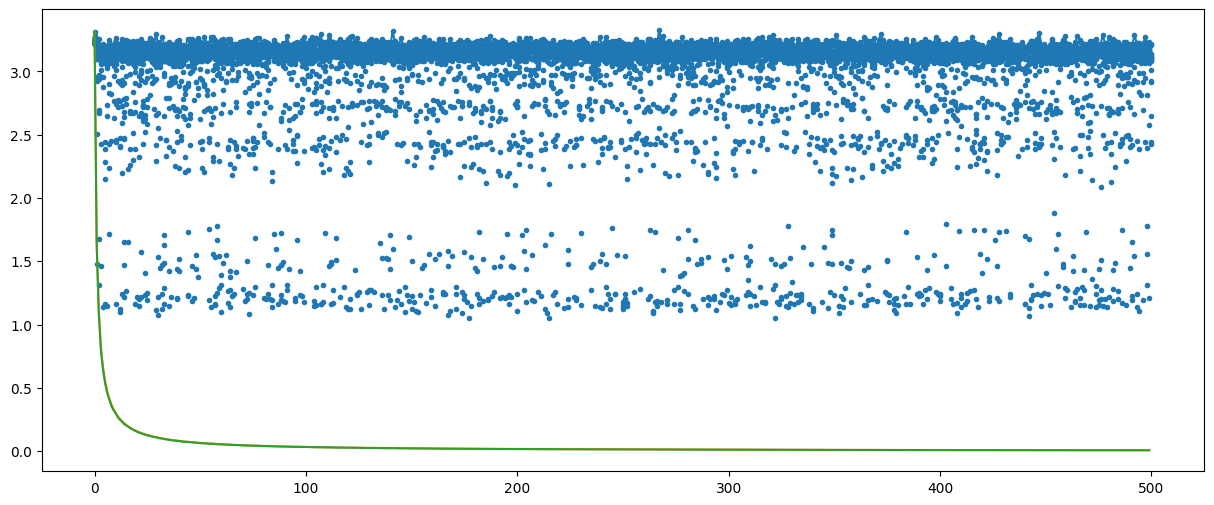

In [29]:
off_line = [max(f[1] for f in fitness_log if f[0] == x) / (x + 1) for x in range(NUM_GENERATIONS)]
on_line = [max(f[1] for f in fitness_log if f[0] <= x) / (x + 1) for x in range(NUM_GENERATIONS)]
gen_best = [max(f[1] for f in fitness_log if f[0] == x) for x in range(NUM_GENERATIONS)]

plt.figure(figsize=(15, 6))
plt.scatter([x for x, _ in fitness_log], [y for _, y in fitness_log], marker=".")
plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)])
plt.plot([x for x, _ in enumerate(on_line)], [y for _, y in enumerate(on_line)])
plt.plot([x for x, _ in enumerate(off_line)], [y for _, y in enumerate(off_line)])

### The evaluation

#### Match against the random strategy

In [30]:
evaluate(evolved_strategy, random_strategy)

N = 2 - Win ratio: 0.54
N = 3 - Win ratio: 0.68
N = 4 - Win ratio: 0.82
N = 5 - Win ratio: 0.71


#### Match against the best human strategy

In [31]:
evaluate(evolved_strategy, best_human_strategy[0], second_num_law=best_human_strategy[1])

N = 2 - Win ratio: 0.5
N = 3 - Win ratio: 1.0
N = 4 - Win ratio: 1.0
N = 5 - Win ratio: 1.0


## An agent using minmax

I am maximizing my possible reward.<br>
My opponent is minimizing my possible reward (so maximizing his reward).

When it's my turn:
- Calculate all the possible moves.
- Calculate all the possible moved for my opponent (for each of my moves)
- Keep on calculating, until all the possible combinations end in someone winning.
- Alpha beta pruning was included in the implementation.
- Pick the path that maximize my reward.

In [32]:
def minmax(nim: Nim, alpha = -1, beta = 1, player = 1, depth = 0):
    if depth > 10:
        return None, -player
    if not nim:
        #print(f"End at depth {depth} - Player {0 if player == 1 else 1}")
        return None, player
    evaluations = list()
    for ply in possible_moves(nim):
        #print(f"Player {0 if player == 1 else 1} - Move {depth}: {ply}")
        board = deepcopy(nim)
        board.nimming(ply)
        _, val = minmax(board, alpha=alpha, beta=beta, player=-player, depth=depth+1)
        evaluations.append((ply, val))
        if player == 1:
            beta = min(beta, val)
        else:
            alpha = max(alpha, val)
        if beta <= alpha:
            break
    if player == 1:
        return min(evaluations, key=lambda k: k[1])
    else:
        return max(evaluations, key=lambda k: k[1])

In [33]:
def minmax_strategy(nim: Nim, num_law=None, nimming=True):
    best_ply, _ = minmax(nim)
    if nimming:
        nim.nimming(best_ply)
    return best_ply

### Match against random strategy

In [34]:
evaluate(minmax_strategy, random_strategy, rows=[2, 3])
evaluate(minmax_strategy, random_strategy, rows=[4], num_matches=10)

N = 2 - Win ratio: 0.85
N = 3 - Win ratio: 1.0
N = 4 - Win ratio: 1.0


### Match against best human strategy

In [35]:
evaluate(minmax_strategy, best_human_strategy[0], second_num_law=best_human_strategy[1], rows=[2, 3])
evaluate(minmax_strategy, best_human_strategy[0], second_num_law=best_human_strategy[1], rows=[4], num_matches=10)

N = 2 - Win ratio: 1.0
N = 3 - Win ratio: 1.0
N = 4 - Win ratio: 1.0


### Match against evolved strategy

In [38]:
evaluate(minmax_strategy, evolved_strategy, rows=[2, 3])
evaluate(minmax_strategy, evolved_strategy, rows=[4], num_matches=10)

N = 2 - Win ratio: 1.0
N = 3 - Win ratio: 1.0
N = 4 - Win ratio: 1.0


### Match against nim sum strategy

The minmax strategy makes the first move.

In [92]:
evaluate(minmax_strategy, nim_sum_strategy, rows=[2, 3], starter=0)
evaluate(minmax_strategy, nim_sum_strategy, rows=[4], num_matches=10, starter=0)

N = 2 - Win ratio: 1.0
N = 3 - Win ratio: 1.0
N = 4 - Win ratio: 0.0


The nimsum strategy makes the first move.

In [40]:
evaluate(minmax_strategy, nim_sum_strategy, rows=[2, 3], starter=1)
evaluate(minmax_strategy, nim_sum_strategy, rows=[4], num_matches=10, starter=1)

N = 2 - Win ratio: 0.0
N = 3 - Win ratio: 0.0
N = 4 - Win ratio: 0.7


## An agent using reinforcement learning

In [41]:
class Agent(object):
    def __init__(self, states, alpha=0.15, random_factor=0.2):  # 80% explore, 20% exploit
        self.state_history = [(states.rows, 0)]  # state, reward
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}

    def choose_action(self, state, allowedMoves):
        maxG = -10e15
        next_move = None
        randomN = np.random.random()
        if randomN < self.random_factor:
            # if random number below random factor, choose random action
            next_move = random.choice(allowedMoves)

            new_state = deepcopy(state)
            new_state.nimming(next_move)
            if new_state.rows not in self.G.keys():
                self.G[new_state.rows] = np.random.uniform(low=1.0, high=0.1)
        else:
            # if exploiting, gather all possible actions and choose one with the highest G (reward)
            for action in allowedMoves:
                new_state = deepcopy(state)
                new_state.nimming(action)

                if new_state.rows not in self.G.keys():
                    self.G[new_state.rows] = np.random.uniform(low=1.0, high=0.1)
                
                if self.G[new_state.rows] >= maxG:
                    next_move = action
                    maxG = self.G[new_state.rows]

        return next_move

    def update_state_history(self, state, reward):
        self.state_history.append((state.rows, reward))

    def learn(self):
        target = 0

        for prev, reward in reversed(self.state_history):
            if prev not in self.G.keys():
                self.G[prev] = np.random.uniform(low=1.0, high=0.1)
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward

        self.state_history = []

        self.random_factor -= 10e-5  # decrease random factor each episode of play


### The reward

The agents gets a 1 reward if the move he does is the winning one (the last move of the game), 0 otherwise.

In [42]:
def get_reward(nim: Nim):
    return 0 if nim else 1

### The learning phase

During the learning phase, the agent is trained against the random strategy. 10000 matches are performed and, at the end, the agent improves significantly.

In [43]:
def train(agent: Agent, opponent_strategy, opponent_law=None):
    NUM_MATCHES = 10000
    NIM_NUM = 5
    nim = Nim(NIM_NUM)
    rateHistory = []
    indices = []
    win_ratio = 0
    for match in range(NUM_MATCHES):
        while nim:
            action = agent.choose_action(nim, possible_moves(nim))
            nim.nimming(action)
            reward = get_reward(nim)
            agent.update_state_history(nim, reward)
            if nim:
                opponent_strategy(nim, opponent_law)
        if nim.turn == 1:
            win_ratio +=1
        agent.learn()
        if match % 100 == 0:
            rateHistory.append(win_ratio / 100)
            indices.append(match)
            win_ratio = 0
        nim = Nim(NIM_NUM)

    plt.semilogy(indices, rateHistory, "b")
    plt.show()

### Reinforcement learning against random strategy

In [67]:
NUM_ROWS = 5
nim = Nim(NUM_ROWS)
rl_agent = Agent(nim, alpha=0.1, random_factor=0.4)

In [68]:
def rl_strategy(nim: Nim, num_law=None, nimming=True):
    action = rl_agent.choose_action(nim, possible_moves(nim))
    if nimming:
        nim.nimming(action)
    return action

#### The first evaluation

In [69]:
evaluate(rl_strategy, random_strategy, rows=[NUM_ROWS], starter=0)

N = 5 - Win ratio: 0.47


#### The training phase

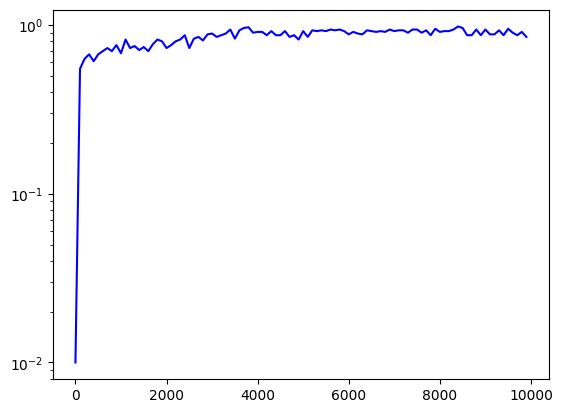

In [70]:
train(rl_agent, random_strategy, None)

#### The second evaluation

In [71]:
evaluate(rl_strategy, random_strategy, rows=[NUM_ROWS], starter=0)

N = 5 - Win ratio: 0.89


### RL against best human strategy

In [78]:
nim = Nim(NUM_ROWS)
rl_agent = Agent(nim, alpha=0.1, random_factor=0.4)

#### The first evaluation

In [79]:
evaluate(rl_strategy, best_human_strategy[0], second_num_law=best_human_strategy[1], rows=[NUM_ROWS], starter=0)

N = 5 - Win ratio: 0.63


#### The learning phase

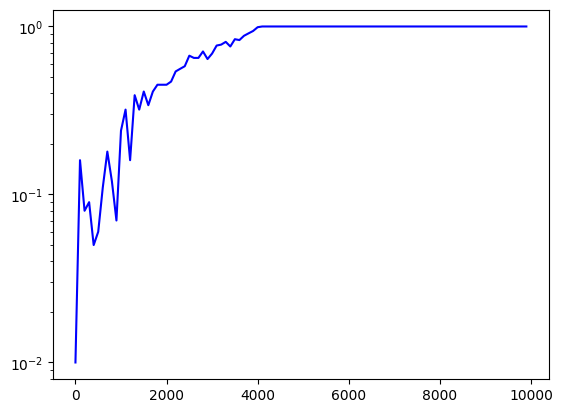

In [80]:
train(rl_agent, best_human_strategy[0], opponent_law=best_human_strategy[1])

#### The second evaluation

In [82]:
evaluate(rl_strategy, best_human_strategy[0], second_num_law=best_human_strategy[1], rows=[NUM_ROWS], starter=0)

N = 5 - Win ratio: 1.0


### RL against evolved strategy

In [83]:
nim = Nim(NUM_ROWS)
rl_agent = Agent(nim, alpha=0.1, random_factor=0.4)

#### The first evaluation

In [84]:
evaluate(rl_strategy, evolved_strategy, rows=[NUM_ROWS], starter=0)

N = 5 - Win ratio: 0.08


#### The learning phase

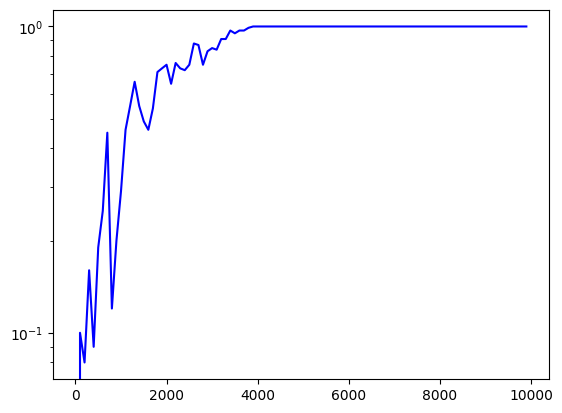

In [85]:
train(rl_agent, evolved_strategy)

#### The second evaluation

In [86]:
evaluate(rl_strategy, evolved_strategy, rows=[NUM_ROWS], starter=0)

N = 5 - Win ratio: 1.0


### RL against nim sum strategy

In [87]:
nim = Nim(NUM_ROWS)
rl_agent = Agent(nim, alpha=0.1, random_factor=0.4)

#### The first evaluation

In [88]:
evaluate(rl_strategy, nim_sum_strategy, rows=[NUM_ROWS], starter=0)

N = 5 - Win ratio: 0.0


#### The learning phase

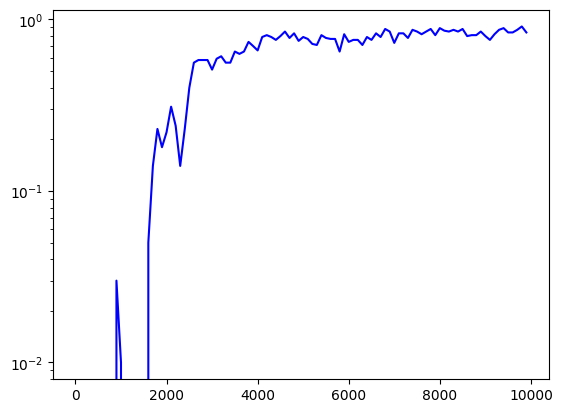

In [89]:
train(rl_agent, nim_sum_strategy)

#### The second evaluation

In [90]:
evaluate(rl_strategy, nim_sum_strategy, rows=[NUM_ROWS], starter=0)

N = 5 - Win ratio: 0.83
